In [712]:
import pandas as pd
import numpy as np
import os
import csv

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [713]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

def plot_all_outputs(df,title):
    """
    Plots all load-related, PV-related, battery-related outputs, and prices from the given DataFrame with interactive features.
    
    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the necessary columns.
    """
    # Create a 2x2 subplot grid
    fig = make_subplots(rows=2, cols=2, subplot_titles=("Load-Related Outputs", "SOC-Related Outputs",
                                                        "Battery-Related Outputs", "Retail and Export Prices"))

    # Plot Load Outputs in the first subplot
    load_columns = ['E_grid_load', 'E_PV_load', 'E_batt_load', 'E_demand', 'E_cons']
    for col in load_columns:
        if col in df.columns:
            fig.add_trace(go.Scatter(x=df.index, y=df[col] * (-1 if col in ['E_demand', 'E_cons'] else 1),
                                     mode='lines', name=col), row=1, col=1)

    # Plot PV Outputs in the second subplot
    pv_columns = ['E_PV_batt', 'E_PV_curt', 'E_PV_grid', 'E_PV_load', 'E_PV', 'EV_minSOC', 'SOC','E_batt_grid']
    for col in pv_columns:
        if col in df.columns:
            fig.add_trace(go.Scatter(x=df.index, y=df[col] * (1 if col in ['SOC'] else df.SOC.max()/100 ),
                                     mode='lines', name=col), row=1, col=2)

    # Plot Battery Outputs in the third subplot
    battery_columns = ['EV_home', 'E_batt_grid', 'E_char_away', 'E_char', 'E_dis', 'EV_away', 'E_batt_load']
    for col in battery_columns:
        if col in df.columns:
            fig.add_trace(go.Scatter(x=df.index, y=df[col] * (-1 if col == 'E_batt_grid' else 1),
                                     mode='lines', name=col), row=2, col=1)

    # Plot Prices in the fourth subplot
    price_columns = ['Import_price', 'Export_price']
    for col in price_columns:
        if col in df.columns:
            fig.add_trace(go.Scatter(x=df.index, y=df[col], mode='lines', name=col), row=2, col=2)

    # Update layout for interactivity
    fig.update_layout(height=800, width=1200, title_text=title, showlegend=True)

    # Show the interactive plot
    fig.show()

In [714]:
df=pd.read_csv('../Output/df_26934(Building-902141-CH513082523745)_NMC_0100_31_0100_SFH100.csv')

In [715]:
df.SOC.describe()

count    8760.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: SOC, dtype: float64

<Axes: >

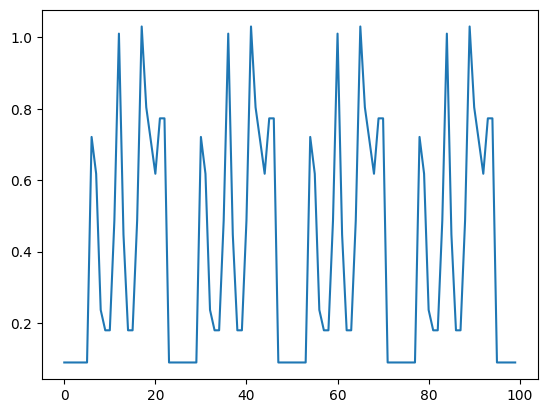

In [716]:
df.E_demand[0:100].plot()

<Axes: >

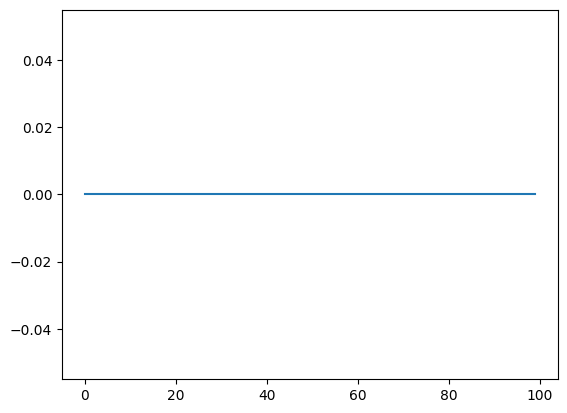

In [717]:
df.SOC[0:100].plot()

In [718]:
df.columns

Index(['index', 'Bool_char', 'Bool_char_EV', 'Bool_cons', 'Bool_dis',
       'Bool_dis_EV', 'Bool_hp', 'Bool_hpdhw', 'Bool_inj', 'E_PV_batt',
       'E_PV_batt_EV', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt', 'E_PV_grid',
       'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_EV_bu', 'E_batt_EV_budhw',
       'E_batt_EV_grid', 'E_batt_EV_hp', 'E_batt_EV_hpdhw', 'E_batt_EV_load',
       'E_batt_bu', 'E_batt_budhw', 'E_batt_hp', 'E_batt_hpdhw', 'E_batt_load',
       'E_bu', 'E_budhw', 'E_char', 'E_char_EV', 'E_char_away', 'E_cons',
       'E_dis', 'E_dis_EV', 'E_grid_batt', 'E_grid_batt_EV', 'E_grid_bu',
       'E_grid_budhw', 'E_grid_hp', 'E_grid_hpdhw', 'E_grid_load', 'E_hp',
       'E_hpdhw', 'E_loss_Batt', 'E_loss_Batt_EV', 'E_loss_conv', 'E_loss_inv',
       'E_loss_inv_PV', 'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd',
       'Q_hp_sh', 'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta',
       'Q_ts_sh', 'SOC', 'SOC_EV', 'T_dhwst', 'T_ts', 'E_demand', 'E_PV',
       'Expor

In [719]:
cols=['E_PV','E_demand','E_hp','E_EV_trip']

In [720]:
df.loc[:,cols[1:]].sum().sum()

np.float64(10269.606609549543)

In [721]:
def compute_kpis(data):
    if data['E_PV'] > 0:
        
        TSC = (data['E_PV_load'] + data['E_PV_batt'] + data['E_PV_bu'] +
               data['E_PV_budhw'] + data['E_PV_hp'] + data['E_PV_hpdhw'] +
               data['E_PV_batt_EV']) / data['E_PV'] * 100
        DSC = (data['E_PV_load'] + data['E_PV_bu'] + data['E_PV_budhw'] +
               data['E_PV_hp'] + data['E_PV_hpdhw'] + data['E_PV_batt_EV']) / data['E_PV'] * 100
        ISC = data['E_PV_batt'] / data['E_PV'] * 100        
    else:
        TSC = DSC = ISC = 0
    denom = data['E_EV_trip'] + data['E_demand'] + data['E_hp']
    TSS = (data['E_PV_load'] + data['E_batt_load'] + data['E_PV_bu'] +
               data['E_PV_budhw'] + data['E_PV_hp'] + data['E_PV_hpdhw'] + 
               data['E_batt_hp'] + data['E_batt_hpdhw'] + data['E_batt_budhw'] + data['E_batt_bu'] +
               data['E_PV_batt_EV']) / denom * 100 if denom > 0 else 0

    return (round(TSC,1), round(DSC,1), round(ISC,1), round(TSS,1))

In [722]:
[TSC,DSC,ISC,TSS]=compute_kpis(df.sum())

In [723]:
TSC

np.float64(22.7)

In [724]:
df.loc[:,['E_PV','E_demand']].min(axis=1).sum()/df.E_PV.sum()

np.float64(0.06155042154582916)

In [725]:
df.loc[:,['E_PV','E_hp']].min(axis=1).sum()/df.E_PV.sum()

np.float64(0.08120497251641415)

In [726]:
df.E_PV_batt_EV.sum()/df.E_PV.sum()

np.float64(0.12273221742805038)

In [727]:
df.E_cons.sum()

np.float64(2025.1574946775627)

In [728]:
(1-df.E_cons.sum()/df.loc[:,cols[1:]].sum().sum())

np.float64(0.8028008694320967)

In [781]:
df.columns

Index(['index', 'Bool_char', 'Bool_char_EV', 'Bool_cons', 'Bool_dis',
       'Bool_dis_EV', 'Bool_hp', 'Bool_hpdhw', 'Bool_inj', 'E_PV_batt',
       'E_PV_batt_EV', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt', 'E_PV_grid',
       'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_EV_bu', 'E_batt_EV_budhw',
       'E_batt_EV_grid', 'E_batt_EV_hp', 'E_batt_EV_hpdhw', 'E_batt_EV_load',
       'E_batt_bu', 'E_batt_budhw', 'E_batt_hp', 'E_batt_hpdhw', 'E_batt_load',
       'E_bu', 'E_budhw', 'E_char', 'E_char_EV', 'E_char_away', 'E_cons',
       'E_dis', 'E_dis_EV', 'E_grid_batt', 'E_grid_batt_EV', 'E_grid_bu',
       'E_grid_budhw', 'E_grid_hp', 'E_grid_hpdhw', 'E_grid_load', 'E_hp',
       'E_hpdhw', 'E_loss_Batt', 'E_loss_Batt_EV', 'E_loss_conv', 'E_loss_inv',
       'E_loss_inv_PV', 'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd',
       'Q_hp_sh', 'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta',
       'Q_ts_sh', 'SOC', 'SOC_EV', 'T_dhwst', 'T_ts', 'E_demand', 'E_PV',
       'Expor

<Axes: >

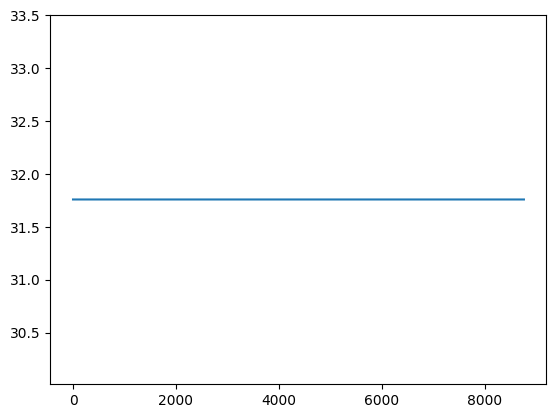

In [782]:
df.price.plot()

Conso total

In [729]:
df.loc[:,cols[1:]].sum().sum()

np.float64(10269.606609549543)

In [730]:
# conso covered by the grid wrt the total
df.E_cons.sum()/df.loc[:,cols[1:]].sum().sum()

np.float64(0.19719913056790328)

In [731]:
(df['E_PV_load'] + df['E_batt_load'] + df['E_PV_bu'] +
               df['E_PV_budhw'] + df['E_PV_hp'] + df['E_PV_hpdhw'] + 
               df['E_batt_hp'] + df['E_batt_hpdhw'] + df['E_batt_budhw'] + df['E_batt_bu'] + df['E_batt_EV_load']+
               df['E_PV_batt_EV']-df['E_EV_trip']).sum()/df.loc[:,cols[1:]].sum().sum()

np.float64(0.5183061727709541)

In [732]:
(df.E_demand-(df.E_PV_load+df.E_batt_load+ df.E_batt_EV_load+df.E_grid_load)).sum()

np.float64(-8.85218606749838e-10)

In [733]:
df.E_dis_EV.describe()

count    8760.000000
mean        0.190043
std         0.272978
min         0.000000
25%         0.000000
50%         0.090000
75%         0.190077
max         1.030000
Name: E_dis_EV, dtype: float64

<Axes: >

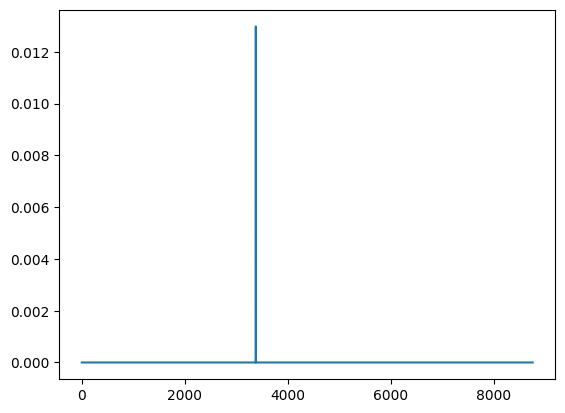

In [734]:
df.E_grid_batt_EV.plot()

In [778]:
((df.E_char_away+df.E_char_EV)-df.E_EV_trip-df.E_dis_EV-df.E_loss_Batt_EV).sum()

np.float64(-1.1593837001555585e-09)

In [736]:
df.SOC_EV.describe()

count    8760.000000
mean       58.532084
std         2.549879
min        46.327600
25%        58.031000
50%        59.640000
75%        60.000000
max        60.000000
Name: SOC_EV, dtype: float64

In [737]:
df.E_batt_EV_load.sum()

np.float64(1664.7751543766133)

In [738]:
df.E_char_away.sum()

np.float64(1547.347822266847)

In [739]:
df.E_char_EV.sum()

np.float64(3803.541102514809)

In [740]:
df.E_dis_EV.sum()

np.float64(1664.7751543766133)

In [741]:
df.E_batt_EV_load.sum()+df.E_loss_Batt_EV.sum()

np.float64(1976.6655247828157)

In [742]:
df.E_batt_EV_grid.sum()

np.float64(0.0)

In [743]:
df.E_EV_trip.sum()

np.float64(3374.2234000000003)

In [744]:
(df.E_char_away+df.E_char_EV).sum()

np.float64(5350.888924781657)

In [745]:
df.E_dis_EV.sum()

np.float64(1664.7751543766133)

In [746]:
-df.E_batt_EV_load.sum()-df.E_loss_Batt_EV.sum()

np.float64(-1976.6655247828157)

In [747]:
df.E_grid_batt_EV.sum()

np.float64(0.0129821350762347)

In [748]:
df.E_PV_batt_EV.sum()

np.float64(3803.528120379733)

In [749]:
df.E_dis_EV.sum()

np.float64(1664.7751543766133)

In [750]:
df.E_batt_EV_grid.sum()

np.float64(0.0)

<Axes: >

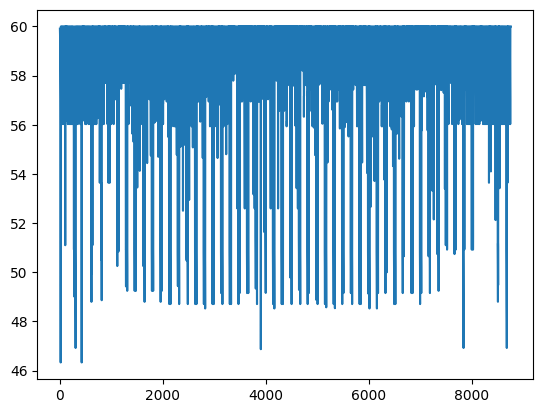

In [751]:
df.SOC_EV.plot()

<Axes: >

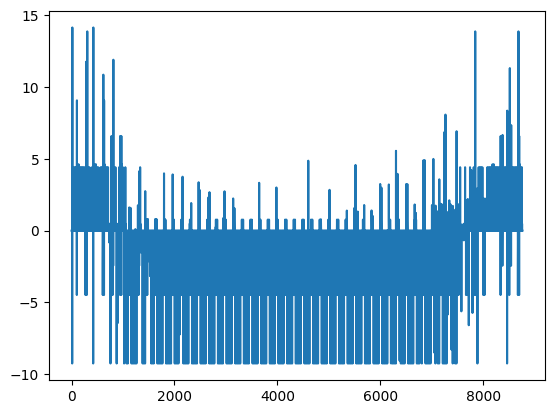

In [752]:
(df.E_char_away-df.E_EV_trip).plot()

In [753]:
df.columns

Index(['index', 'Bool_char', 'Bool_char_EV', 'Bool_cons', 'Bool_dis',
       'Bool_dis_EV', 'Bool_hp', 'Bool_hpdhw', 'Bool_inj', 'E_PV_batt',
       'E_PV_batt_EV', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt', 'E_PV_grid',
       'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_EV_bu', 'E_batt_EV_budhw',
       'E_batt_EV_grid', 'E_batt_EV_hp', 'E_batt_EV_hpdhw', 'E_batt_EV_load',
       'E_batt_bu', 'E_batt_budhw', 'E_batt_hp', 'E_batt_hpdhw', 'E_batt_load',
       'E_bu', 'E_budhw', 'E_char', 'E_char_EV', 'E_char_away', 'E_cons',
       'E_dis', 'E_dis_EV', 'E_grid_batt', 'E_grid_batt_EV', 'E_grid_bu',
       'E_grid_budhw', 'E_grid_hp', 'E_grid_hpdhw', 'E_grid_load', 'E_hp',
       'E_hpdhw', 'E_loss_Batt', 'E_loss_Batt_EV', 'E_loss_conv', 'E_loss_inv',
       'E_loss_inv_PV', 'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd',
       'Q_hp_sh', 'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta',
       'Q_ts_sh', 'SOC', 'SOC_EV', 'T_dhwst', 'T_ts', 'E_demand', 'E_PV',
       'Expor

In [754]:
df.E_cons.sum()

np.float64(2025.1574946775627)

In [755]:
(df.E_grid_batt_EV+df.E_grid_hpdhw+df.E_grid_hp+df.E_grid_bu+df.E_grid_load).sum()

np.float64(2025.1574946775625)

In [756]:
df.loc[:,cols[1:]].sum().sum()

np.float64(10269.606609549543)

In [757]:
1-(df.E_grid_batt_EV+df.E_grid_hpdhw+df.E_grid_hp+df.E_grid_bu+df.E_grid_load).sum()/df.loc[:,cols[1:]].sum().sum()

np.float64(0.8028008694320967)

In [758]:
TSS

np.float64(68.5)

In [759]:
a=4000
b=a+100


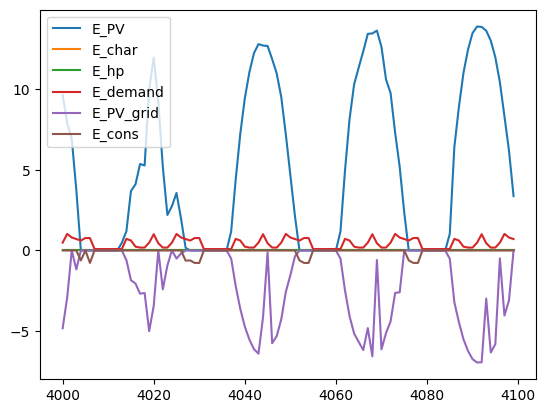

In [760]:
df.E_PV[a:b].plot()
df.E_char[a:b].plot()
df.E_hp[a:b].plot()
df.E_demand[a:b].plot()
(-1*df.E_PV_grid[a:b]).plot()
(-1*df.E_cons[a:b]).plot()
plt.legend()

In [761]:
print(df.E_hp.sum())
print(df.E_demand.sum())
print(df.E_EV_trip.sum())

3220.9282095495428
3674.4549999999995
3374.2234000000003


In [762]:
(df.E_PV-df.E_PV_grid-df.E_loss_inv_PV-df.E_PV_curt).sum()/df.E_PV.sum()*100

np.float64(22.691655075298698)

In [763]:
(df.E_PV_batt+df.E_PV_batt_EV+df.E_PV_bu+df.E_PV_budhw+df.E_PV_hp+df.E_PV_hpdhw+df.E_PV_load).sum()/df.E_PV.sum()

np.float64(0.22691655075301245)

In [764]:
df.E_batt_EV_grid.sum()

np.float64(0.0)

In [765]:
df.E_PV_curt.sum()

np.float64(49.248833259483256)

In [766]:
df.columns

Index(['index', 'Bool_char', 'Bool_char_EV', 'Bool_cons', 'Bool_dis',
       'Bool_dis_EV', 'Bool_hp', 'Bool_hpdhw', 'Bool_inj', 'E_PV_batt',
       'E_PV_batt_EV', 'E_PV_bu', 'E_PV_budhw', 'E_PV_curt', 'E_PV_grid',
       'E_PV_hp', 'E_PV_hpdhw', 'E_PV_load', 'E_batt_EV_bu', 'E_batt_EV_budhw',
       'E_batt_EV_grid', 'E_batt_EV_hp', 'E_batt_EV_hpdhw', 'E_batt_EV_load',
       'E_batt_bu', 'E_batt_budhw', 'E_batt_hp', 'E_batt_hpdhw', 'E_batt_load',
       'E_bu', 'E_budhw', 'E_char', 'E_char_EV', 'E_char_away', 'E_cons',
       'E_dis', 'E_dis_EV', 'E_grid_batt', 'E_grid_batt_EV', 'E_grid_bu',
       'E_grid_budhw', 'E_grid_hp', 'E_grid_hpdhw', 'E_grid_load', 'E_hp',
       'E_hpdhw', 'E_loss_Batt', 'E_loss_Batt_EV', 'E_loss_conv', 'E_loss_inv',
       'E_loss_inv_PV', 'E_loss_inv_batt', 'E_loss_inv_grid', 'Q_dhwst_hd',
       'Q_hp_sh', 'Q_hp_ts', 'Q_loss_dhwst', 'Q_loss_ts', 'Q_ts', 'Q_ts_delta',
       'Q_ts_sh', 'SOC', 'SOC_EV', 'T_dhwst', 'T_ts', 'E_demand', 'E_PV',
       'Expor

In [767]:
df.E_char_EV.describe()

count    8760.000000
mean        0.434194
std         1.722809
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        11.000000
Name: E_char_EV, dtype: float64

In [768]:
df.E_hp.describe()

count    8760.000000
mean        0.367686
std         1.094577
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         5.500000
Name: E_hp, dtype: float64

In [769]:
df.COP_SH.describe()

count    8760.000000
mean        4.796985
std         1.429697
min         1.820000
25%         3.710000
50%         4.920000
75%         6.430000
max         6.430000
Name: COP_SH, dtype: float64

<Axes: >

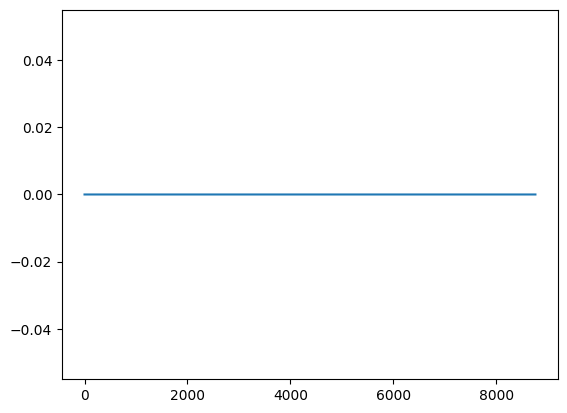

In [770]:
df.SOC.plot()

<Axes: >

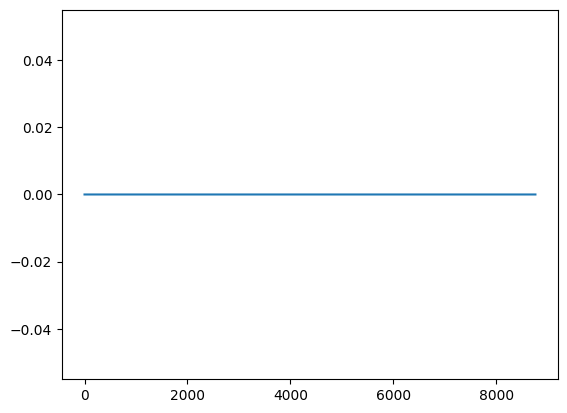

In [771]:
df.E_dis.plot()

In [772]:
df.E_hp.sum()

np.float64(3220.9282095495428)

<Axes: >

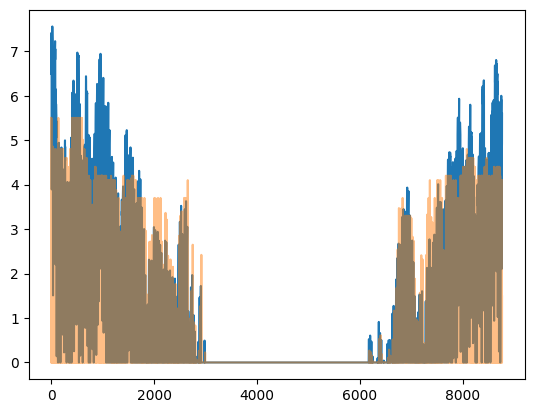

In [773]:
df.Req_kWh.plot()

df.E_hp.plot(alpha=0.5)


In [774]:
df.Req_kWh.describe()

count    8760.000000
mean        1.256723
std         1.839193
min         0.000000
25%         0.000000
50%         0.000000
75%         2.421000
max         7.557000
Name: Req_kWh, dtype: float64

In [775]:
plot_all_outputs(df,'building')

In [776]:
def plot_df(df):
    # Assume df is your DataFrame containing the columns
    fig, axs = plt.subplots(3, 3, figsize=(18, 18), constrained_layout=True)
    axs = axs.flatten()

    # Subplot 1: Main PV Production (usage and curtailment)
    axs[0].plot(df['E_PV_load'], label='PV Load')
    axs[0].plot(df['E_PV_grid'], label='PV Grid Injection')
    axs[0].plot(df['E_PV_curt'], label='PV Curtailment')
    axs[0].set_title('Main PV Production')
    axs[0].set_ylabel('kWh')	
    axs[0].legend()

    # Subplot 2: PV Allocation to Battery and HP
    axs[1].plot(df['E_PV_batt'], label='PV to Battery')
    axs[1].plot(df['E_PV_batt_EV'], label='PV to EV')

    axs[1].plot(df['E_PV_hp'], label='PV to Heat Pump')

    axs[1].set_title('PV to EV,Batt and HP')
    axs[1].set_ylabel('kWh')	
    axs[1].legend()

    # Subplot 3: Battery Operation (non-EV)
    axs[2].plot(df['E_char'], label='Battery Charge')
    axs[2].plot(df['E_dis'], label='Battery Discharge')
    axs[2].plot(df['SOC'], label='Battery SOC')
    axs[2].set_title('Battery Operation')
    axs[2].set_ylabel('kWh')
    axs[2].legend()

    # Subplot 4: EV-Related Flows
    axs[3].plot(df['E_batt_EV_load'], label='EV Load')
    axs[3].plot(df['E_char_EV'], label='EV Charge')
    axs[3].plot(df['E_dis_EV'], label='EV Discharge')
    axs[3].plot(df['SOC_EV'], label='EV SOC')
    axs[3].set_title('EV Flows')
    axs[3].set_ylabel('kWh')
    axs[3].legend()

    # Subplot 5: Grid Interaction
    axs[4].plot(df['E_cons'], label='Grid Consumption')
    axs[4].plot(df['E_grid_batt'], label='Grid to Battery')
    axs[4].plot(df['E_grid_load'], label='Grid to Load')
    axs[4].set_title('Grid Interaction')
    axs[4].set_ylabel('kWh')
    axs[4].legend()

    # Subplot 6: Heat Pump Performance
    axs[5].plot(df['E_hp'], label='HP Energy')
    axs[5].plot(df['E_hpdhw'], label='HP DHW Energy')
    axs[5].set_title('Heat Pump Performance')
    axs[5].set_ylabel('kWh')
    axs[5].legend()

    # Subplot 7: Backup Heater Flows
    axs[6].plot(df['E_bu'], label='Backup Heater')
    axs[6].plot(df['E_budhw'], label='Backup DHW')
    axs[6].set_title('Backup Heater Flows')
    axs[6].set_ylabel('kWh')
    axs[6].legend()

    # Subplot 8: Thermal Temperatures
    axs[7].plot(df['T_ts'], label='Tank Temperature')
    axs[7].plot(df['T_dhwst'], label='DHW Tank Temperature')
    axs[7].set_title('Thermal Temperatures')
    axs[7].set_ylabel('K')
    axs[7].legend()

    # Subplot 9: Thermal Energy Flows
    axs[8].plot(df['Q_hp_sh'], label='HP Space Heating')
    axs[8].plot(df['Q_hp_ts'], label='HP Tank Charging')
    axs[8].plot(df['Q_dhwst_hd'], label='DHW Demand Heating')
    axs[8].set_title('Thermal Energy Flows')
    axs[8].set_ylabel('kWh')
    axs[8].legend()

    plt.tight_layout()
    plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05, wspace=0.3, hspace=0.4)

    plt.show()

In [777]:
df=pd.read_csv('../Output/df_26930(Building-902138-CH895237183088)_NMC_0100_17_1100_SFH100.csv')

FileNotFoundError: [Errno 2] No such file or directory: '../Output/df_26930(Building-902138-CH895237183088)_NMC_0100_17_1100_SFH100.csv'

In [ ]:
df.head()

,index,Bool_char,Bool_char_EV,Bool_cons,Bool_dis,Bool_dis_EV,Bool_hp,Bool_hpdhw,Bool_inj,E_PV_batt,...,Req_kWh_DHW,Set_T,Temp,Temp_supply,Temp_supply_tank,T_aux_supply,COP_tank,COP_SH,COP_DHW,E_EV_trip
0,2017-01-01 00:00:00+01:00,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,293.15,271.15,315.446983,319.214268,325.446983,1.81,2.06,1.62,0.0
1,2017-01-01 01:00:00+01:00,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,293.15,271.05,315.446983,319.214268,325.446983,1.81,2.06,1.62,0.0
2,2017-01-01 02:00:00+01:00,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.000000,293.15,270.95,315.446983,319.214268,325.446983,1.81,2.06,1.62,0.0
3,2017-01-01 03:00:00+01:00,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.010796,293.15,270.85,315.446983,319.214268,325.446983,1.81,2.06,1.62,0.0
4,2017-01-01 04:00:00+01:00,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.049600,293.15,270.55,315.446983,319.214268,325.446983,1.81,2.06,1.62,0.0


C:\Users\alejandr.penabell\AppData\Local\Temp\ipykernel_53420\334176635.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


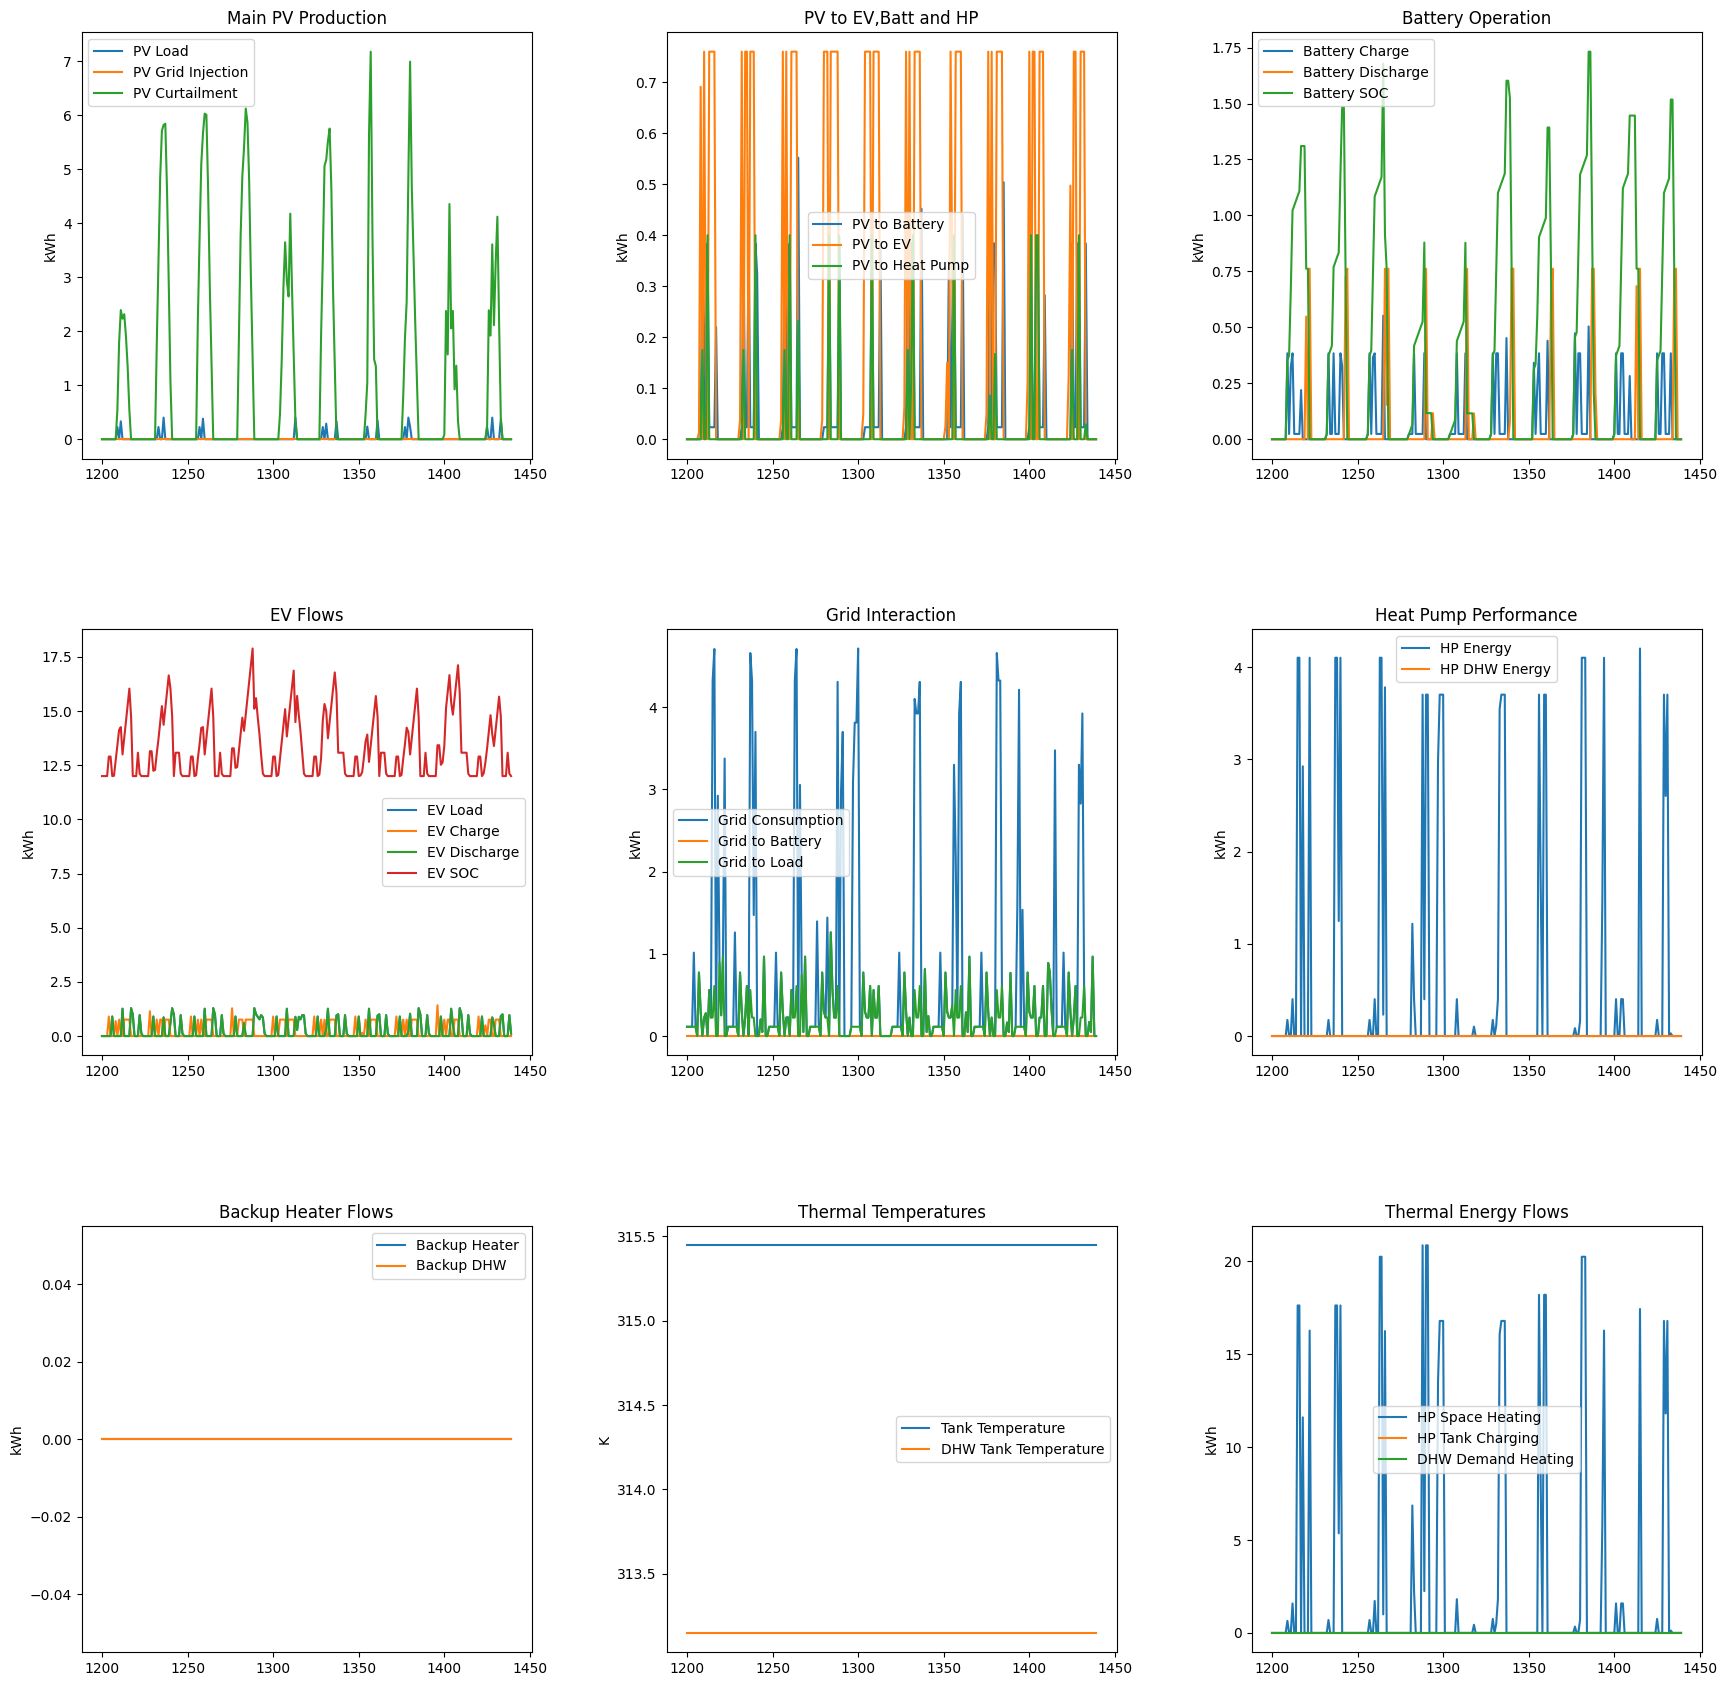

In [ ]:
plot_df(df.iloc[24*50:24*60,:])

In [ ]:
df=pd.read_csv('../Output/df_Low119187_284984_NMC_0100_7_0100_SFH100.csv')

C:\Users\alejandr.penabell\AppData\Local\Temp\ipykernel_32060\334176635.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


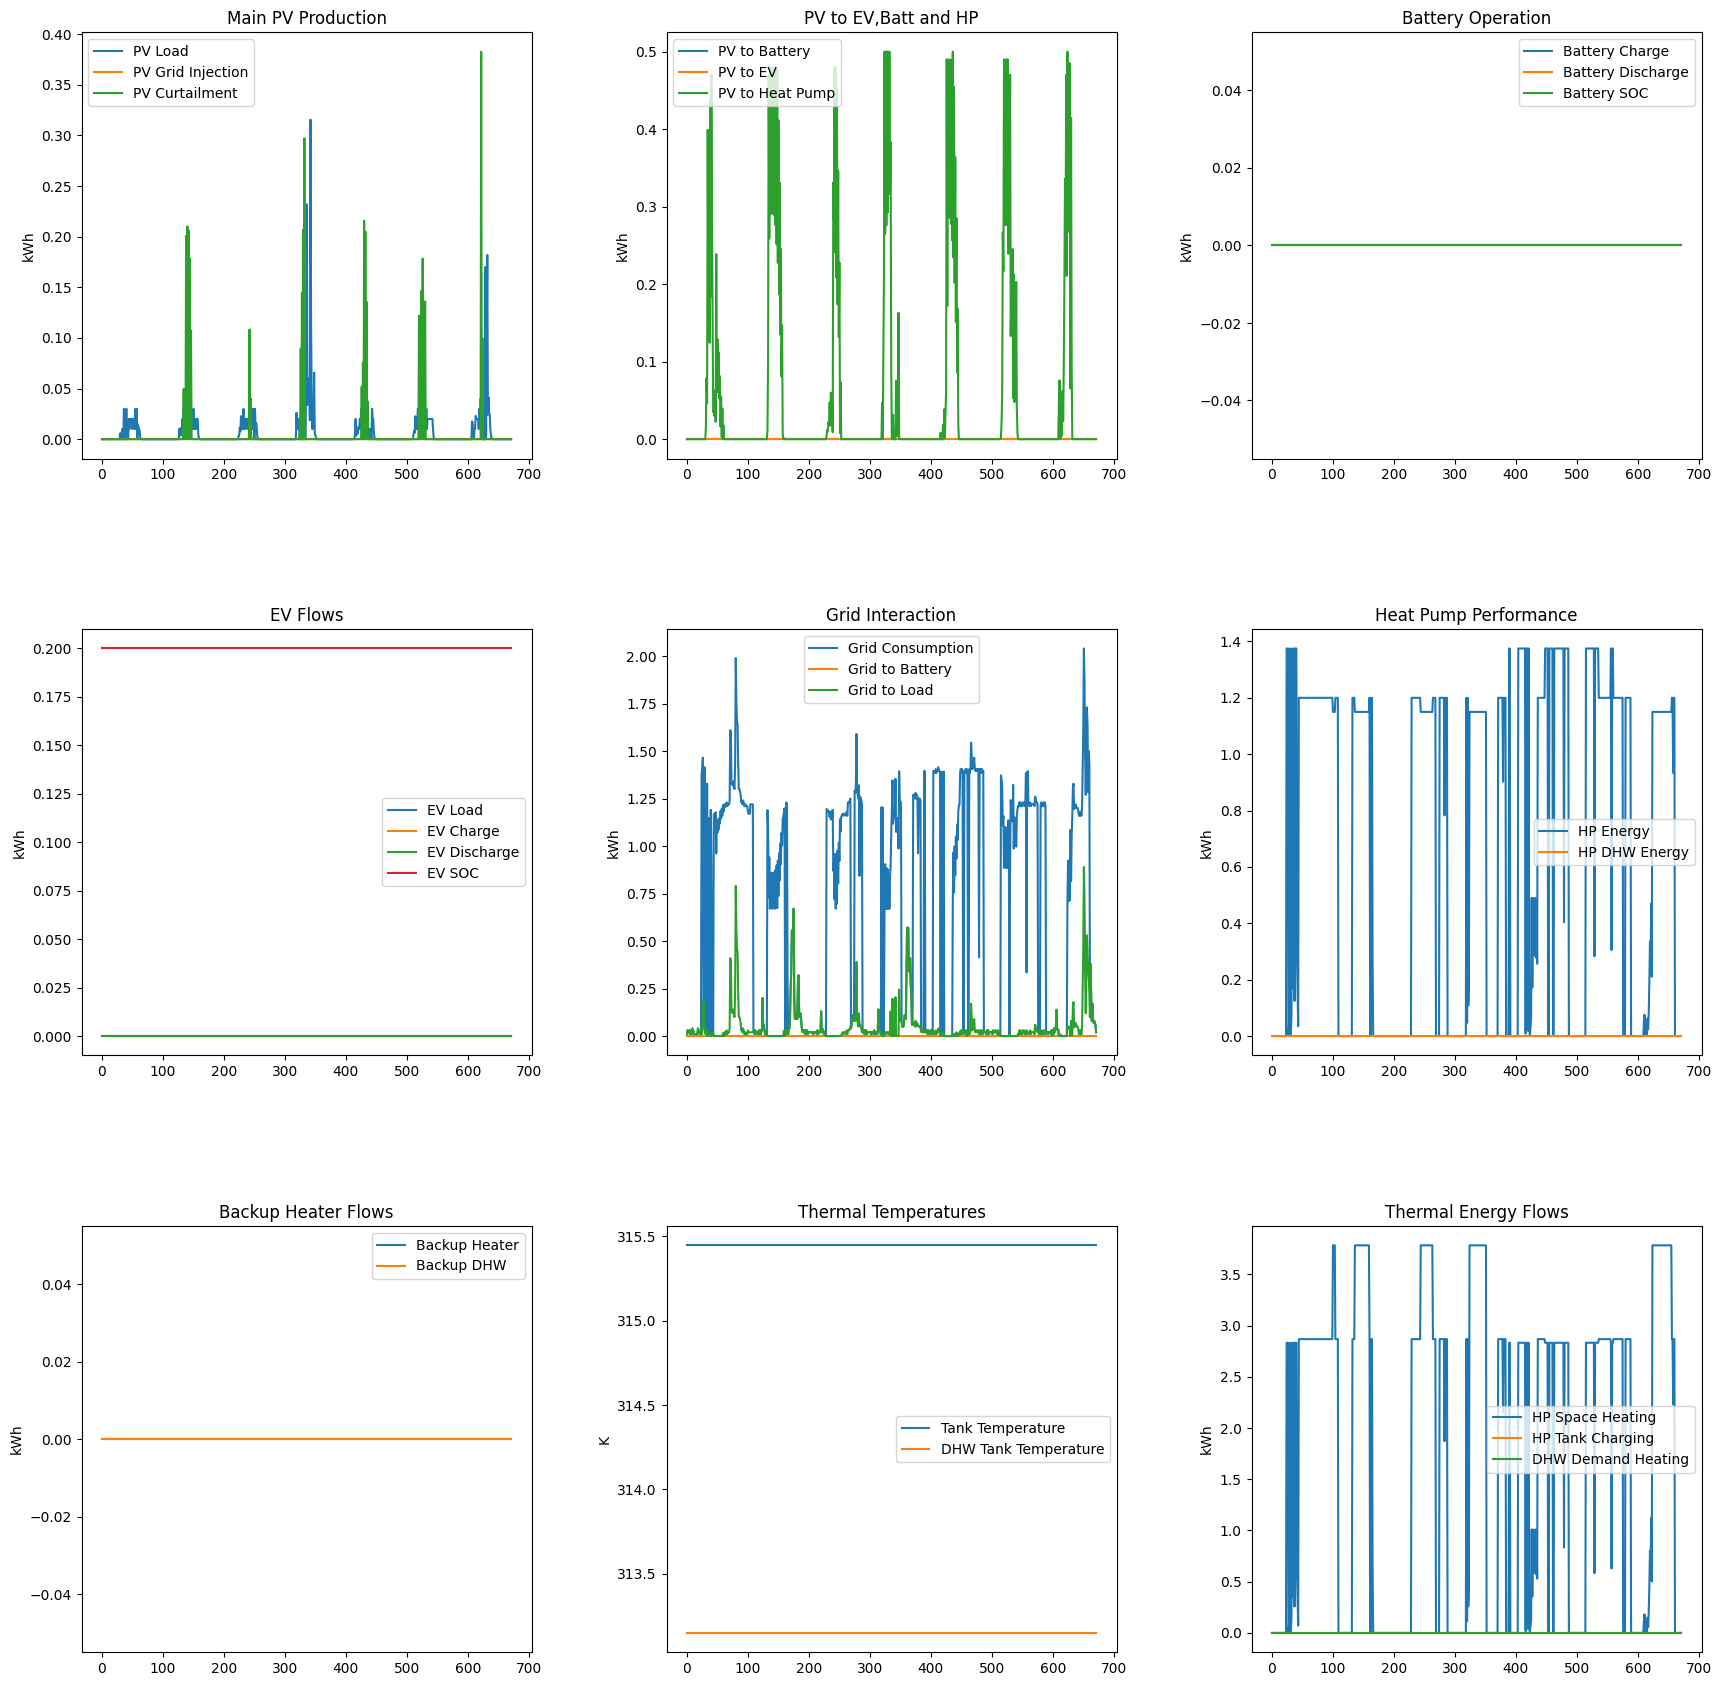

In [ ]:
plot_df(df)

In [ ]:
df=pd.read_csv('../Output/df_Low426842_415443_NMC_0100_7_0101_SFH100.csv')

C:\Users\alejandr.penabell\AppData\Local\Temp\ipykernel_32060\334176635.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


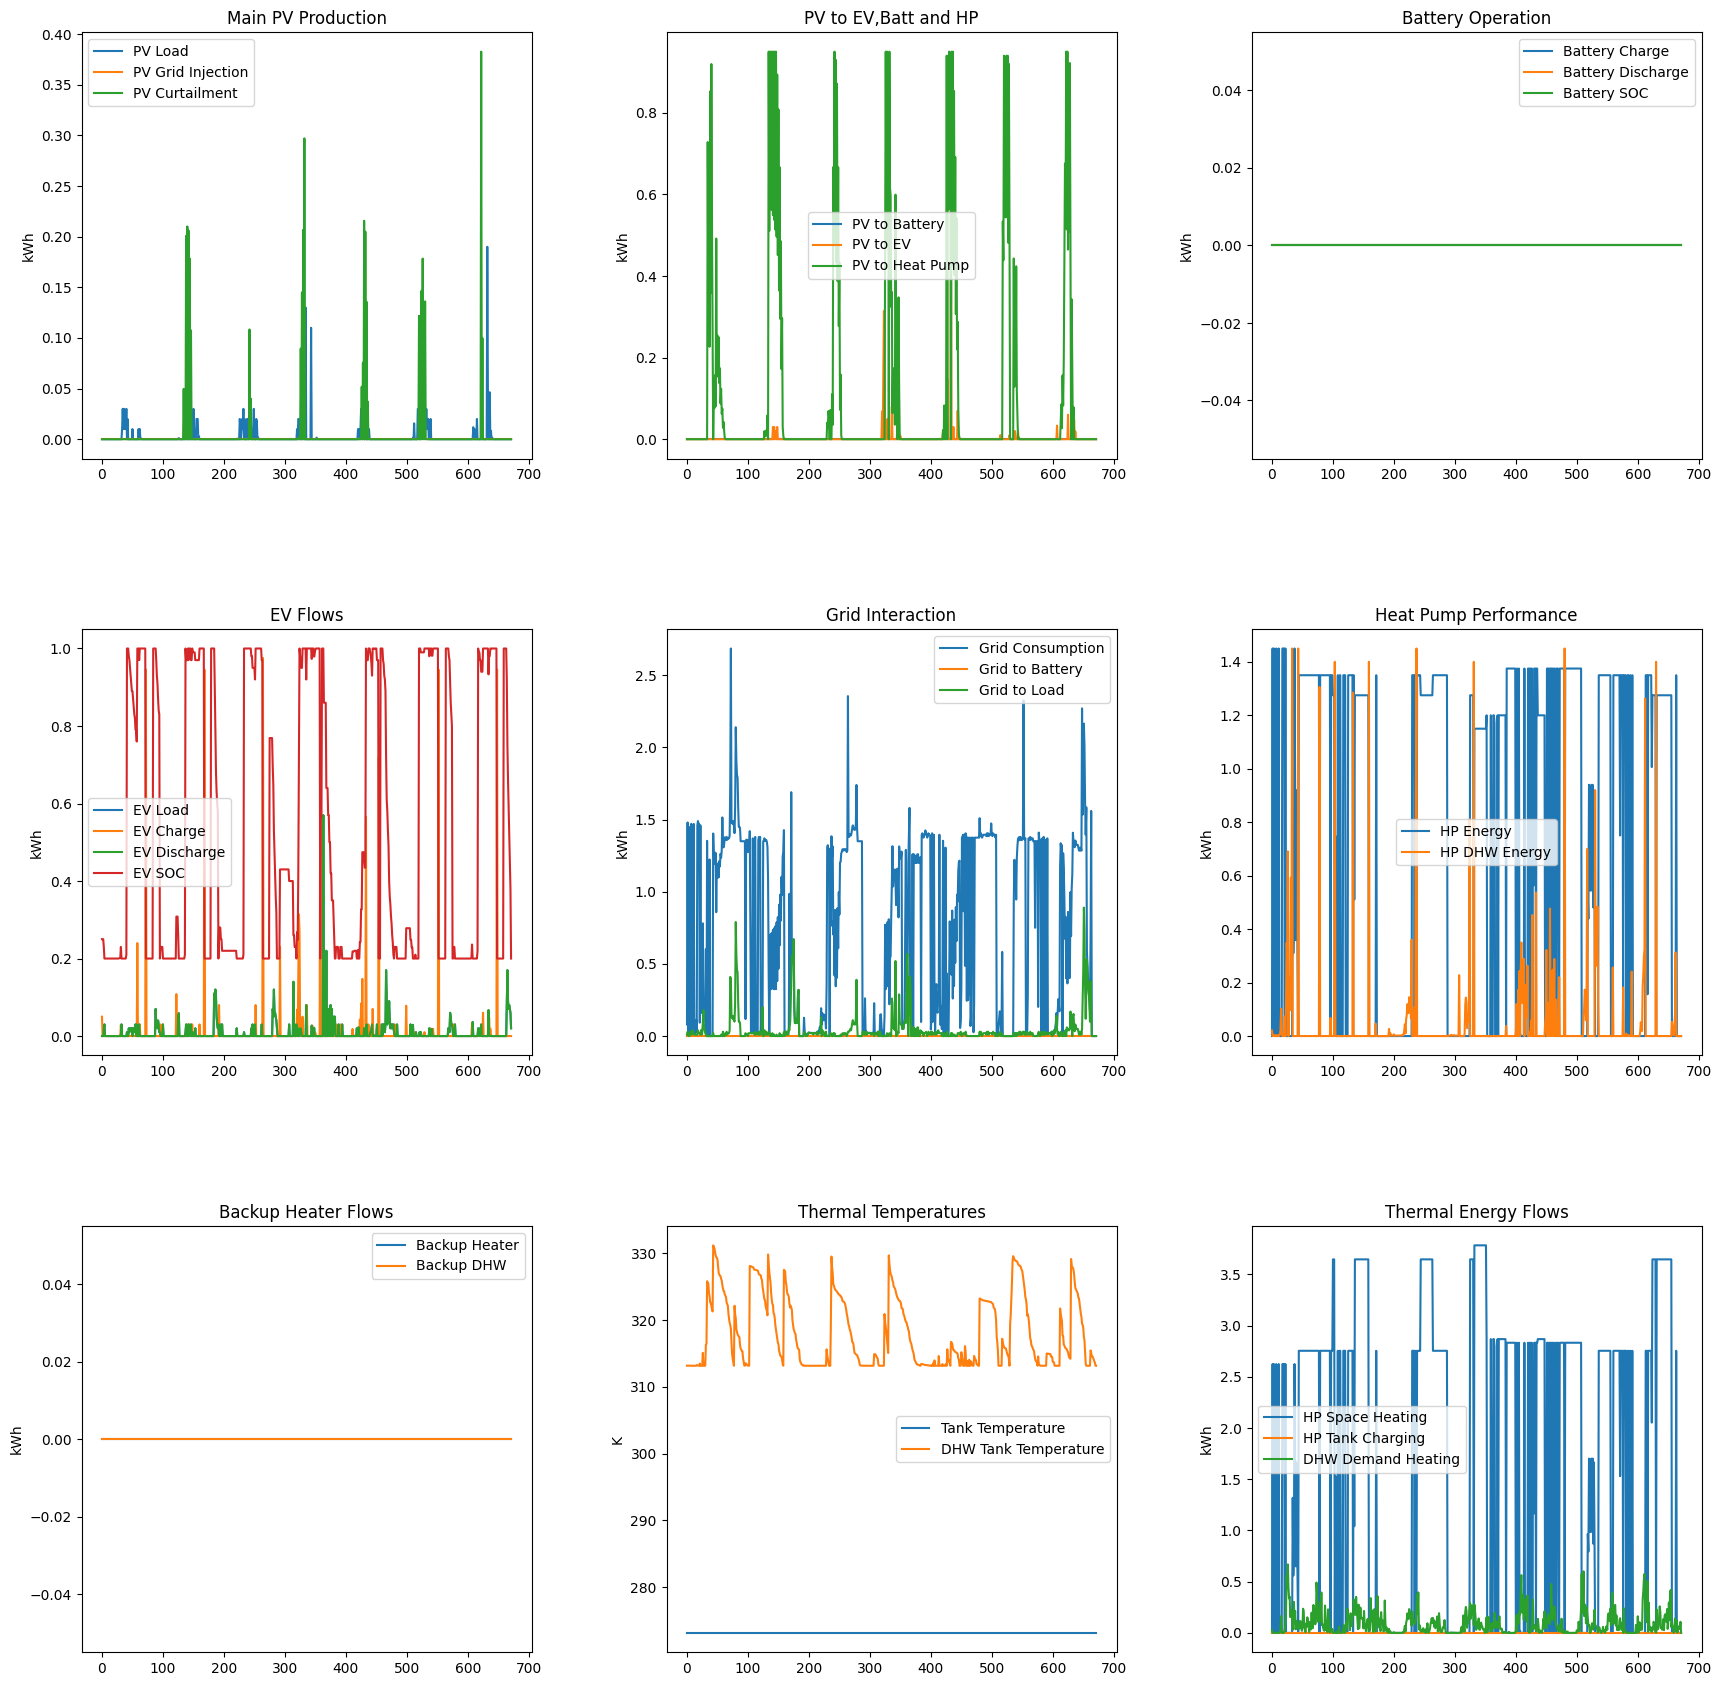

In [ ]:
plot_df(df)